In [1]:
import os
os.chdir('../../../')

import pandas as pd
import numpy as np
import pickle

from lsmm_data import LSMMData
import json

with open('data/assembly/pyr_rect.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

Filtering to pyramidal cells only
459


c:\Users\trevo\anaconda3\envs\analysis\Lib\site-packages\lsmm_data\LSMMData.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['connectome_index'] = data['structural']['post_cell'].index
c:\Users\trevo\anaconda3\envs\analysis\Lib\site-packages\lsmm_data\LSMMData.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['pt_position'] = [[data['structural']['post_cell'].iloc[i]['pt_position_x'],data['structural']['post_cell'].iloc[i]['pt_position

Generating Connectome...


100%|██████████| 44293/44293 [03:42<00:00, 199.30it/s]


Generating Connectome...


100%|██████████| 44293/44293 [01:53<00:00, 389.29it/s]


In [2]:
# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index

synapse_table = data_a['structural']['synapse']

assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Filter cell tables to only assembly cells
cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

pre_root_ids = set(cell_table['pt_root_id'].values)
post_root_ids = set(post_cell_table['pt_root_id'].values)
all_root_ids = pre_root_ids | post_root_ids

In [3]:
# Prep the sets

# Collect w, s, and b
w = {}
s = {}
b = {}

# collect each potential pre, post combination
for pre in pre_root_ids:
    for post in post_root_ids:
        if pre != post:
            w[(pre, post)] = 0
            s[(pre, post)] = 0
            b[(pre, post)] = 0

# from the synapse table, aggregate total summed PSD, synapse count, and binary presence of connectivity
for i, row in synapses_df.iterrows():
    pre = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w[(pre, post)] += row['size']
    s[(pre, post)] += 1
    b[(pre, post)] = 1

# Split out assemblies and no_a
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
no_A = set(assembly_to_root_ids['No A'])
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in all_root_ids if 'No A' not in mappings_a['assemblies_by_pt_root_id'][pt_root_id]}

# C functions
def shared(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def disjoint(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def shared_no_a(pre, post, A):
    return (pre in no_A) and (post in no_A)
    
def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A)

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A)

C = [shared, disjoint, shared_no_a, no_a_a, a_no_a]

In [4]:
# Calculate the pairwise binary connectivity and summed PSD sets

W_nonzero_pair = {}
B_pair = {}
for c in C:
    W_nonzero_pair[c.__name__] = {}
    B_pair[c.__name__] = {}
    for (j, i) in w.keys():
        if c(j, i, A):
            B_pair[c.__name__][(j, i)] = 1 if w[(j, i)] > 0 else 0
            if w[(j, i)] > 0:
                W_nonzero_pair[c.__name__][(j, i)] = w[(j, i)]

# Pairwise Shared v Between Connections

## Chi-Sq for Binary Connectivity

Contingency Table: [[38, 1195], [56, 2151]]
Chi-squared Test Statistic: 0.6895237264027132
P-value: 0.40632642626291404


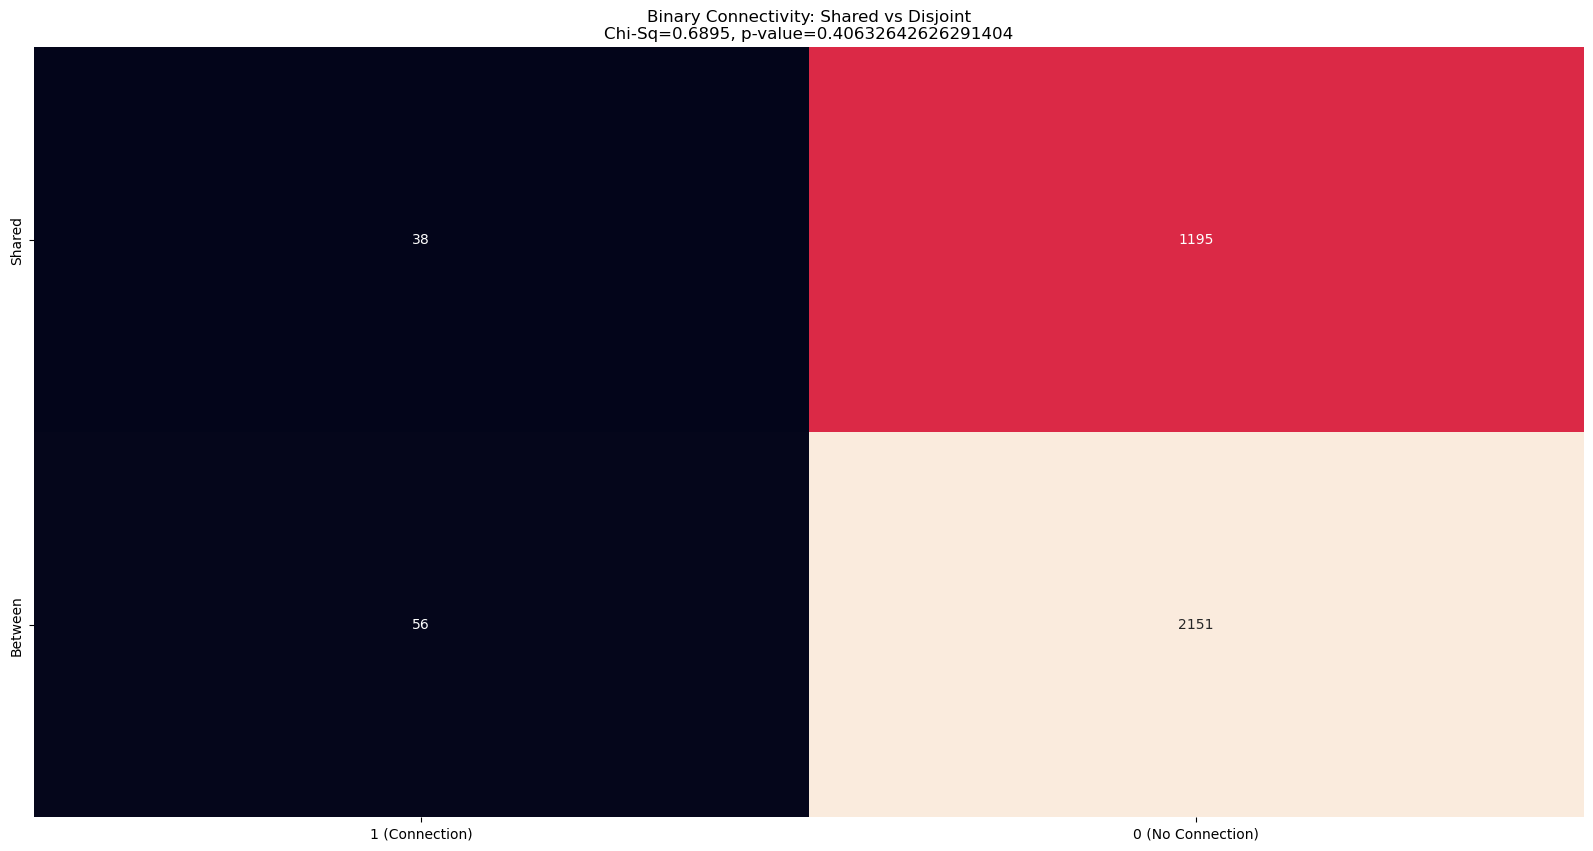

In [5]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

contingency_table = [
    [sum(value == 1 for value in B_pair['shared'].values()), sum(value == 0 for value in B_pair['shared'].values())],
    [sum(value == 1 for value in B_pair['disjoint'].values()), sum(value == 0 for value in B_pair['disjoint'].values())]
]
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Contingency Table:", contingency_table)
print(f"Chi-squared Test Statistic: {chi2}")
print(f"P-value: {p}")

plt.figure(figsize=(20, 10))
sns.heatmap(contingency_table, annot=True, fmt="d", cbar=False,
                xticklabels=["1 (Connection)", "0 (No Connection)"], yticklabels=["Shared", "Between"])
plt.title(f'Binary Connectivity: Shared vs Disjoint\nChi-Sq={round(chi2, 4)}, p-value={p}')
plt.show()

[[38, 1195], [56, 2151]] (no autapse) [[38, 1238], [56, 2151]] (with autapse)

# Rank Sum for Pairwise Nonzero Summed Post-Synaptic Densities

C:\Users\trevo\AppData\Local\Temp\ipykernel_24124\823886580.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([shared_values, disjoint_values], labels=['Shared', 'Disjoint'])


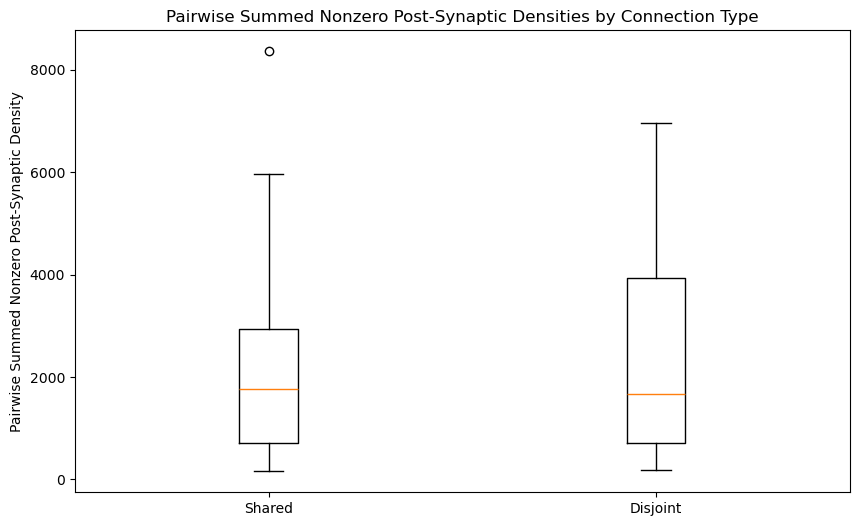

Rank Sum Result (Shared > Disjoint): RanksumsResult(statistic=0.015408948520239999, pvalue=0.4938529621940748)
Rank Sum Result (Shared < Disjoint): RanksumsResult(statistic=0.015408948520239999, pvalue=0.5061470378059252)


C:\Users\trevo\AppData\Local\Temp\ipykernel_24124\823886580.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([shared_log, disjoint_log], labels=['Shared', 'Disjoint'])


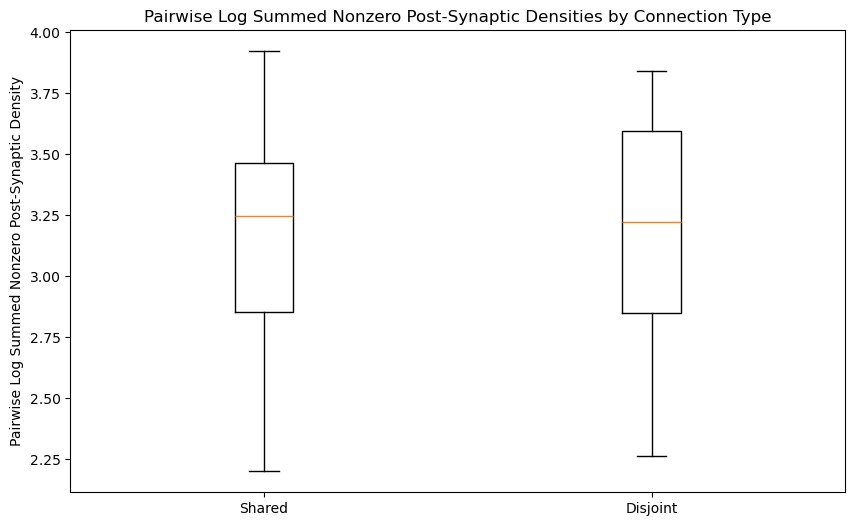

T-Test on Log-Transformed Values Result (Shared > Disjoint): TtestResult(statistic=0.027836013137363384, pvalue=0.48892661799645726, df=92.0)
T-Test on Log-Transformed Values Result (Shared < Disjoint): TtestResult(statistic=0.027836013137363384, pvalue=0.5110733820035427, df=92.0)


In [6]:
from scipy.stats import ttest_ind, levene, ranksums

# lists of values
shared_values = list(W_nonzero_pair['shared'].values())
disjoint_values = list(W_nonzero_pair['disjoint'].values())

# plot untransformed paired summed psds and perform rank-sum test
plt.figure(figsize=(10, 6))
plt.boxplot([shared_values, disjoint_values], labels=['Shared', 'Disjoint'])
plt.ylabel('Pairwise Summed Nonzero Post-Synaptic Density')
plt.title('Pairwise Summed Nonzero Post-Synaptic Densities by Connection Type')
plt.show()

greater_rank_sum_result = ranksums(shared_values, disjoint_values, alternative='greater')
print("Rank Sum Result (Shared > Disjoint):", greater_rank_sum_result)
lesser_rank_sum_result = ranksums(shared_values, disjoint_values, alternative='less')
print("Rank Sum Result (Shared < Disjoint):", lesser_rank_sum_result)

# log transform summed values (log(sum))
shared_log = np.log10(shared_values)
disjoint_log = np.log10(disjoint_values)

# plot and perform T-test on log transformed values
plt.figure(figsize=(10, 6))
plt.boxplot([shared_log, disjoint_log], labels=['Shared', 'Disjoint'])
plt.ylabel('Pairwise Log Summed Nonzero Post-Synaptic Density')
plt.title('Pairwise Log Summed Nonzero Post-Synaptic Densities by Connection Type')
plt.show()

levene_test_result = levene(shared_log, disjoint_log)
#print("Levene's Test For Equal Variance:", levene_test_result)

greater_t_test_result = ttest_ind(shared_log, disjoint_log, equal_var=True, alternative='greater')
print("T-Test on Log-Transformed Values Result (Shared > Disjoint):", greater_t_test_result)
lesser_t_test_result = ttest_ind(shared_log, disjoint_log, equal_var=True, alternative='less')
print("T-Test on Log-Transformed Values Result (Shared < Disjoint):", lesser_t_test_result)

# Outbound, Inbound NONZERO sum PSD.

In [7]:
# what if a pre-cell has connections in one C type but not the other? Only include those with both? but then n decreases
# also note that there are no autapses in synapses_df, so even if we sum across all post-cells (including post-cell = pre-cell), still okay
W_nonzero_out = {}
for c in C:
    W_nonzero_out[c.__name__] = {}
    for j in pre_root_ids:
        if len([i for i in post_root_ids if i != j and c(j, i, A) and w[j, i] > 0]) > 0:
            W_nonzero_out[c.__name__][j] = sum([w[(j, i)] for i in post_root_ids if c(j, i, A) and j != i]) / len([i for i in post_root_ids if i != j and c(j, i, A) and w[j, i] > 0])

# calculate set of differences between paired cells for the shared, disjoint groups (only including those in both sets)
shared_cells = set(W_nonzero_out.get('shared', {}).keys())
disjoint_cells = set(W_nonzero_out.get('disjoint', {}).keys())
common_cells = shared_cells & disjoint_cells

W_nonzero_out_paired = [W_nonzero_out['shared'][j] - W_nonzero_out['disjoint'][j] for j in common_cells]

W_nonzero_in = {}
for c in C:
    W_nonzero_in[c.__name__] = {}
    for i in post_root_ids:
        if len([j for j in pre_root_ids if c(j, i, A)]) > 0 and len([j for j in pre_root_ids if j != i and c(j, i, A) and w[j,i] > 0]):
            W_nonzero_in[c.__name__][i] = sum([w[(j, i)] for j in pre_root_ids if c(j, i, A) and i != j]) / len([j for j in pre_root_ids if j != i and c(j, i, A) and w[j,i] > 0])

# calculate set of differences between paired cells for the shared, disjoint groups (only including those in both sets)
shared_cells = set(W_nonzero_in.get('shared', {}).keys())
disjoint_cells = set(W_nonzero_in.get('disjoint', {}).keys())
common_cells = shared_cells & disjoint_cells

W_nonzero_in_paired = [W_nonzero_in['shared'][i] - W_nonzero_in['disjoint'][i] for i in common_cells]

B_out = {}
for c in C:
    B_out[c.__name__] = {}
    for j in pre_root_ids:
        if len([i for i in post_root_ids if c(j, i, A) and j != i]) > 0:
            B_out[c.__name__][j] = sum([b[(j, i)] for i in post_root_ids if c(j, i, A) and j != i]) / len([i for i in post_root_ids if c(j, i, A) and j != i])

B_in = {}
for c in C:
    B_in[c.__name__] = {}
    for i in post_root_ids:
        if len([j for j in pre_root_ids if c(j, i, A) and i != j]) > 0:
            B_in[c.__name__][i] = sum([b[(j, i)] for j in pre_root_ids if c(j, i, A) and i != j]) / len([j for j in pre_root_ids if c(j, i, A) and j != i])

# Signed-Rank + Rank-sum Test

## Outbound

C:\Users\trevo\AppData\Local\Temp\ipykernel_24124\876158718.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([W_nonzero_out_paired], labels=['Paired Differences (Shared - Disjoint)'])


# of Outbound Shared Pre-Cells: 22
# of Outbound Disjoint Pre-Cells: 28
# of Pre-Cells Appearing in Both: 14


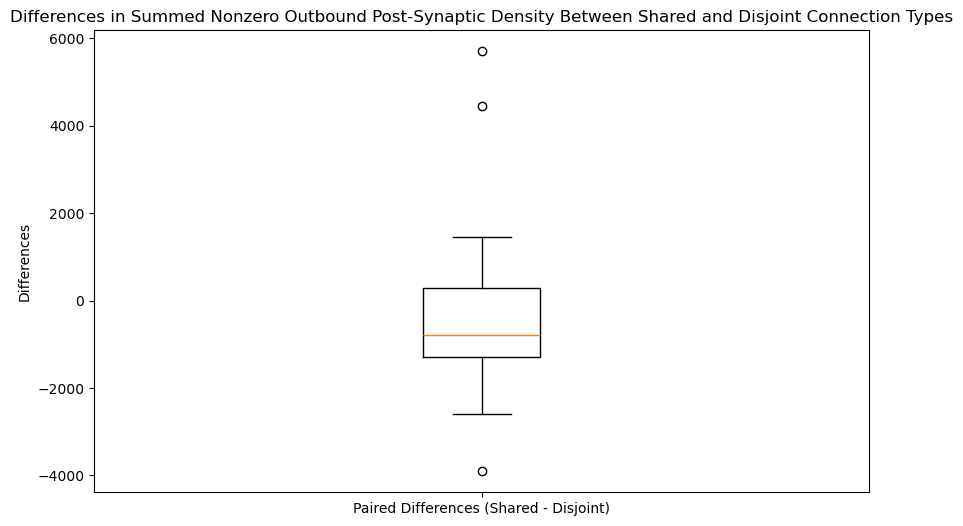

Signed-Rank (Shared > Disjoint): WilcoxonResult(statistic=39.0, pvalue=0.80450439453125)
Signed-Rank Result (Shared < Disjoint): WilcoxonResult(statistic=39.0, pvalue=0.213134765625)


C:\Users\trevo\AppData\Local\Temp\ipykernel_24124\876158718.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([average_nonzero_shared_outbound_values, average_nonzero_disjoint_outbound_values], labels=['Shared', 'Disjoint'])


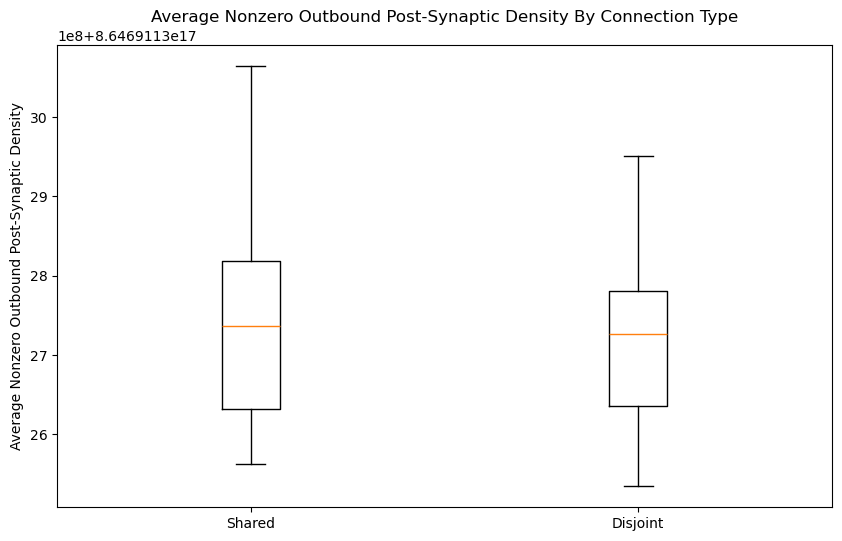

Rank-Sum (Shared > Disjoint): RanksumsResult(statistic=0.547234173495873, pvalue=0.2921089305961549)
Rank-Sum (Disjoint > Shared): RanksumsResult(statistic=0.547234173495873, pvalue=0.7078910694038452)


In [8]:
from scipy.stats import wilcoxon

print('# of Outbound Shared Pre-Cells:', len(W_nonzero_out['shared']))
print('# of Outbound Disjoint Pre-Cells:', len(W_nonzero_out['disjoint']))
print('# of Pre-Cells Appearing in Both:', len(W_nonzero_out_paired))
# differences in paired values
plt.figure(figsize=(10, 6))
plt.boxplot([W_nonzero_out_paired], labels=['Paired Differences (Shared - Disjoint)'])
plt.ylabel('Differences')
plt.title('Differences in Summed Nonzero Outbound Post-Synaptic Density Between Shared and Disjoint Connection Types')
plt.show()

greater_wilcoxon_result = wilcoxon(W_nonzero_out_paired, alternative='greater')
print("Signed-Rank (Shared > Disjoint):", greater_wilcoxon_result)
lesser_wilcoxon_result = wilcoxon(W_nonzero_out_paired, alternative='less')
print("Signed-Rank Result (Shared < Disjoint):", lesser_wilcoxon_result)

average_nonzero_shared_outbound_values = list(W_nonzero_out['shared'])
average_nonzero_disjoint_outbound_values = list(W_nonzero_out['disjoint'])
plt.figure(figsize=(10, 6))
plt.boxplot([average_nonzero_shared_outbound_values, average_nonzero_disjoint_outbound_values], labels=['Shared', 'Disjoint'])
plt.ylabel('Average Nonzero Outbound Post-Synaptic Density')
plt.title('Average Nonzero Outbound Post-Synaptic Density By Connection Type')
plt.show()

greater_ranksum_result = ranksums(average_nonzero_shared_outbound_values, average_nonzero_disjoint_outbound_values, alternative='greater')
print("Rank-Sum (Shared > Disjoint):", greater_ranksum_result)
lesser_ranksum_result = ranksums(average_nonzero_shared_outbound_values, average_nonzero_disjoint_outbound_values, alternative='less')
print("Rank-Sum (Disjoint > Shared):", lesser_ranksum_result)

## Inbound

C:\Users\trevo\AppData\Local\Temp\ipykernel_24124\3492009887.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([W_nonzero_in_paired], labels=['Paired Differences (Shared - Disjoint)'])


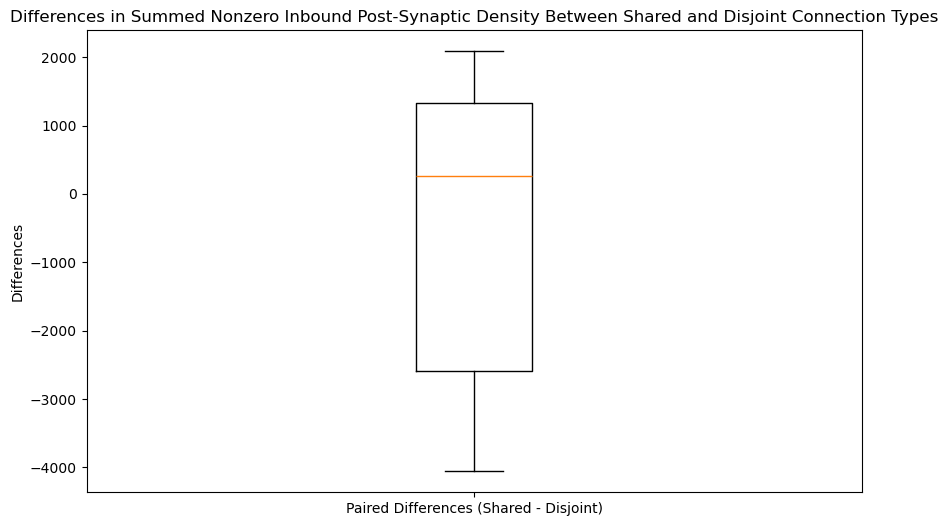

Signed-Rank (Shared > Disjoint): WilcoxonResult(statistic=35.0, pvalue=0.63330078125)
Signed-Rank Result (Shared < Disjoint): WilcoxonResult(statistic=35.0, pvalue=0.3955078125)


C:\Users\trevo\AppData\Local\Temp\ipykernel_24124\3492009887.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([average_nonzero_shared_inbound_values, average_nonzero_disjoint_inbound_values], labels=['Shared', 'Disjoint'])


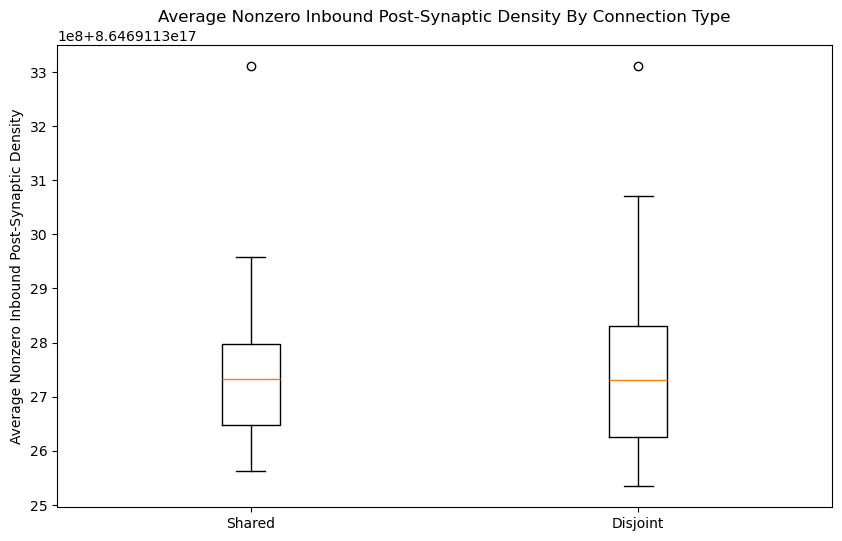

Rank-Sum (Shared > Disjoint): RanksumsResult(statistic=0.03108349360801046, pvalue=0.48760147675090526)
Rank-Sum (Disjoint > Shared): RanksumsResult(statistic=0.03108349360801046, pvalue=0.5123985232490947)


In [9]:
# differences in paired values
plt.figure(figsize=(10, 6))
plt.boxplot([W_nonzero_in_paired], labels=['Paired Differences (Shared - Disjoint)'])
plt.ylabel('Differences')
plt.title('Differences in Summed Nonzero Inbound Post-Synaptic Density Between Shared and Disjoint Connection Types')
plt.show()

greater_wilcoxon_result = wilcoxon(W_nonzero_in_paired, alternative='greater')
print("Signed-Rank (Shared > Disjoint):", greater_wilcoxon_result)
lesser_wilcoxon_result = wilcoxon(W_nonzero_in_paired, alternative='less')
print("Signed-Rank Result (Shared < Disjoint):", lesser_wilcoxon_result)

average_nonzero_shared_inbound_values = list(W_nonzero_in['shared'])
average_nonzero_disjoint_inbound_values = list(W_nonzero_in['disjoint'])
plt.figure(figsize=(10, 6))
plt.boxplot([average_nonzero_shared_inbound_values, average_nonzero_disjoint_inbound_values], labels=['Shared', 'Disjoint'])
plt.ylabel('Average Nonzero Inbound Post-Synaptic Density')
plt.title('Average Nonzero Inbound Post-Synaptic Density By Connection Type')
plt.show()

greater_ranksum_result = ranksums(average_nonzero_shared_inbound_values, average_nonzero_disjoint_inbound_values, alternative='greater')
print("Rank-Sum (Shared > Disjoint):", greater_ranksum_result)
lesser_ranksum_result = ranksums(average_nonzero_shared_inbound_values, average_nonzero_disjoint_inbound_values, alternative='less')
print("Rank-Sum (Disjoint > Shared):", lesser_ranksum_result)

# Outbound, Inbound Connection Probabilities

## Outbound

C:\Users\trevo\AppData\Local\Temp\ipykernel_24124\3291865381.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([shared_oubound_conn_probs, disjoint_outbound_conn_probs], labels=['Shared', 'Disjoint'])


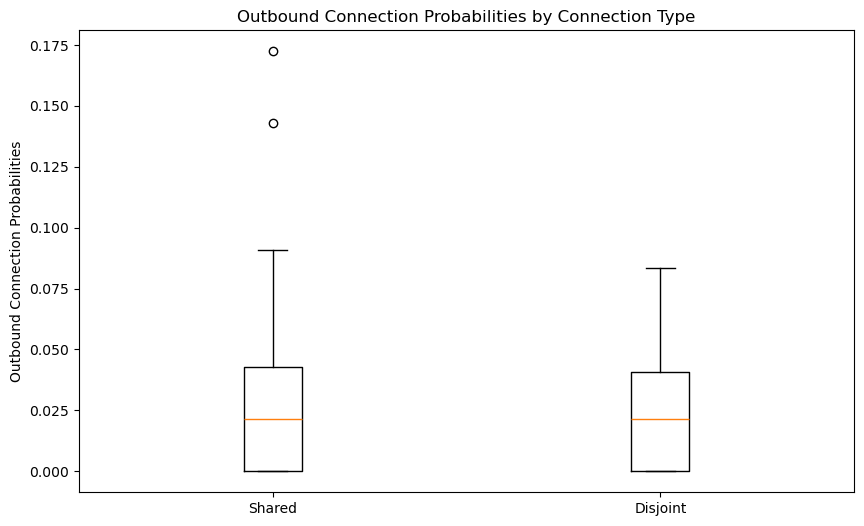

Rank Sum Result (Shared > Disjoint): RanksumsResult(statistic=-0.37796447300922725, pvalue=0.6472715069443633)
Rank Sum Result (Shared < Disjoint): RanksumsResult(statistic=-0.37796447300922725, pvalue=0.3527284930556367)


In [10]:
# lists of values
shared_oubound_conn_probs = list(B_out['shared'].values())
disjoint_outbound_conn_probs = list(B_out['disjoint'].values())

plt.figure(figsize=(10, 6))
plt.boxplot([shared_oubound_conn_probs, disjoint_outbound_conn_probs], labels=['Shared', 'Disjoint'])
plt.ylabel('Outbound Connection Probabilities')
plt.title('Outbound Connection Probabilities by Connection Type')
plt.show()

greater_rank_sum_result = ranksums(shared_oubound_conn_probs, disjoint_outbound_conn_probs, alternative='greater')
print("Rank Sum Result (Shared > Disjoint):", greater_rank_sum_result)
lesser_rank_sum_result = ranksums(shared_oubound_conn_probs, disjoint_outbound_conn_probs, alternative='less')
print("Rank Sum Result (Shared < Disjoint):", lesser_rank_sum_result)

## Inbound

C:\Users\trevo\AppData\Local\Temp\ipykernel_24124\1771855029.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([shared_inbound_conn_probs, disjoint_inbound_conn_probs], labels=['Shared', 'Disjoint'])


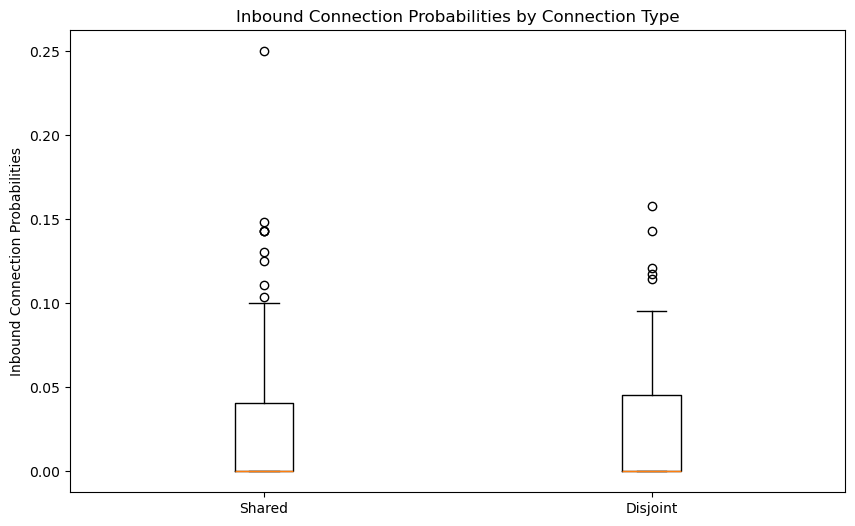

Rank Sum Result (Shared > Disjoint): RanksumsResult(statistic=-1.0545814050512978, pvalue=0.8541915940547842)
Rank Sum Result (Shared < Disjoint): RanksumsResult(statistic=-1.0545814050512978, pvalue=0.14580840594521582)


In [11]:
# lists of values
shared_inbound_conn_probs = list(B_in['shared'].values())
disjoint_inbound_conn_probs = list(B_in['disjoint'].values())

plt.figure(figsize=(10, 6))
plt.boxplot([shared_inbound_conn_probs, disjoint_inbound_conn_probs], labels=['Shared', 'Disjoint'])
plt.ylabel('Inbound Connection Probabilities')
plt.title('Inbound Connection Probabilities by Connection Type')
plt.show()

greater_rank_sum_result = ranksums(shared_inbound_conn_probs, disjoint_inbound_conn_probs, alternative='greater')
print("Rank Sum Result (Shared > Disjoint):", greater_rank_sum_result)
lesser_rank_sum_result = ranksums(shared_inbound_conn_probs, disjoint_inbound_conn_probs, alternative='less')
print("Rank Sum Result (Shared < Disjoint):", lesser_rank_sum_result)